# Exercises Week 6 in 02506: Deformable Models

This week we will dive into deformable models where we will separate a foreground from a background.
<p align="center"> 
  <img src="images/plusplus.png" width="300" title="Plus Plus">
</p>

## Imports

In [1]:
import numpy as np
from skimage.io import imread, imshow, imsave
import matplotlib.pyplot as plt
from skimage import color
import cv2
import scipy.ndimage
import matplotlib.pyplot as plt
from imageio import get_reader
#import easy_snake as es
from skimage.draw import polygon2mask
from snake_functions import *

## 6.4 Exercise: Segmentation and Tracking

### 1. Read in and inspect the movie data. In python you may use function get_reader from imageio package.

In [2]:
problem = 2
if problem == 0:
    mov = get_reader("images/crawling_amoeba.mov")
elif problem == 1:
    mov = get_reader("images/echiniscus.mp4")
else:
    mov = imread("images/plusplus.png")

### 2. Process movie frames. 
For our segmentation method to work, movie
frames need to be transformed in grayscale images with a significant
difference in intensities of the foreground and a background. For
the movie showing the crawling amoeba (which is white on a dark
background), it is enough to convert movie frames to grayscale.
Transforming intensities to doubles between 0 and 1 is advisable, as
it might prevent issues in subsequent processing. For the movie of
the echinicsus, we want to utilize the fact that foreground is yellow
while background is blue. A example of suitable transformation is
$(2b - (r + g) + 2)/4$, with r, g, b being color channels (with values
between 0 and 1).

In [3]:
frames = []
gray_frames = []
if problem == 0 or problem ==1:
        for frame in mov:
                frames.append(frame)
        if problem == 0:
                for col_frame in frames:
                        tmp = col_frame.astype(float)/255.0
                        gray_frames.append(color.rgb2gray(tmp))
        elif problem == 1:
                for col_frame in frames:
                        tmp = col_frame.astype(float)/255.0
                        gray = 0.25*(2.0*tmp[:,:,2]-(tmp[:,:,0]+tmp[:,:,1])+2.0)
                        gray_frames.append(gray)
elif problem == 2:
        frames.append(mov)
        gray_frames.append(color.rgb2gray(mov.astype(float)/255.0))


Text(0.5, 1.0, 'Grayscale')

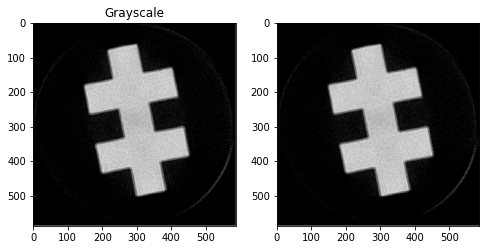

In [4]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))
ax1.imshow(frames[0])
ax1.set_title("Original")
ax2.imshow(gray_frames[0],cmap='gray')
ax1.set_title("Grayscale")

### 3. Choose a starting frame and initialize a snake so that it roughly delineates the foreground object. 
You may define a circular snake with points $(x_0 +r \cos a, y_0 +r \sin a)$, where $(x_0, y_0)$ is a circle center, r is a radius and angular parameter a takes n values from $[0, 2\pi)$.

In [5]:
def get_snake(frame,num_points = 100):
    avals = np.linspace(0,2*np.pi,num_points)
    H,W = np.shape(gray_frames[0])
    r = H/5
    x0 = H/2
    y0 = W/2
    x = np.array([x0+r*np.cos(a) for a in avals])
    y = np.array([y0+r*np.sin(a) for a in avals])
    snake = np.array([x,y]).T.astype(int)
    return snake
snake = get_snake(gray_frames[0])

### 4. Compute mean intensities inside and outside the snake. In python use polygon2mask from package skimage.draw introduced in version 0.16.

In [6]:
def get_int_ext(frame,snake):
    frame_shape = np.shape(frame)
    interior = polygon2mask(frame_shape,snake)
    exterior = np.logical_not(interior)
    return interior, exterior

def get_means(frame,snake):
    frame_shape = np.shape(frame)
    interior, exterior = get_int_ext(frame,snake)
    mu_in = np.mean(gray_frames[0][interior])
    mu_out = np.mean(gray_frames[0][exterior])
    return mu_in,mu_out
    
mu_in,mu_out = get_means(gray_frames[0],snake)
print(f"mu_in={mu_in}\nmu_out={mu_out}")

mu_in=0.5666874013973406
mu_out=0.10865896947045255


### 5. Compute the magnitude of the snake displacement given by Eq. (6.1).
That is, for each snake point, compute the scalar value giving the
(signed) length of the deformation in the normal direction. This
depends on image data under the snake and estimated mean intensities,
as shown in Figure 6.3. A simple approach evaluates the image
intensities under the snake by rounding the coordinates of the snake
points. A more advanced approach involves interpolating the image
at the positions of snake points for example using bilinear interpolation,
which is implemented in interp2 under the scipy.interpolate
package in python.

Equation 6.1 is given by
$F_{ext} = (\mu_{in} - \mu_{out}) (2I- \mu_{in} - \mu_{out}) N$
Where N is the outward pointing unit normal

In [7]:
def get_force(frame,snake,num_points=100):
    mu_in,mu_out = get_means(frame,snake)
    F_ext = np.zeros([num_points,1])
    for i,cords in enumerate(snake):
        x,y = cords
        scale = (mu_in-mu_out)*(2*frame[x,y]-mu_in-mu_out)
        F_ext[i] = scale
    return F_ext

F = get_force(gray_frames[0],snake)

### 6. Write a function which takes snake points C as an input and returnssnake normals N. 
A normal to point ci can be approximated by
a unit vector orthogonal to ci+1 􀀀 ci􀀀1. (Alternatively, and slightly
better, you may average the normals of two line segments meeting
at ci.) 

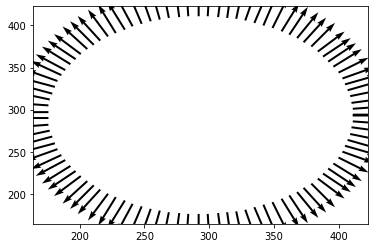

In [8]:
def get_normal(snake,num_points=100):
    N = np.zeros([num_points,2])
    for i,cords in enumerate(snake):
        x,y = cords.astype(float)
        dx1 = (snake[(i+1) % num_points][0] - x)
        dy1 = (snake[(i+1) % num_points][1] - y)
        len1 = np.sqrt(dx1**2+dy1**2)
        dx2 = (x-snake[(i-1) % num_points][0])
        dy2 = (y-snake[(i-1) % num_points][1])
        len2 = np.sqrt(dx2**2+dy2**2)
        vx = (dy1/len1+dy2/len2)/2
        vy = -(dx1/len1+dx2/len2)/2
        lenv = np.sqrt(vx**2+vy**2)
        N[i][0] = vx/lenv
        N[i][1] = vy / lenv
    return N

N = get_normal(snake);

#plt.
#plt.imshow(gray_frames[0])
plt.quiver(snake[:,0],snake[:,1], N[:,0], N[:,1], scale=10)
plt.show()

Displace the snake. Estimate a reasonable value for the size
of the update step by visualizing the displacement. You should
later fine-tune this value so that the segmentation runs sufficiently
fast, but without introducing exaggerated oscillations. This step
corresponds to computing the expression in the parentheses in the
Eq. (6.3).

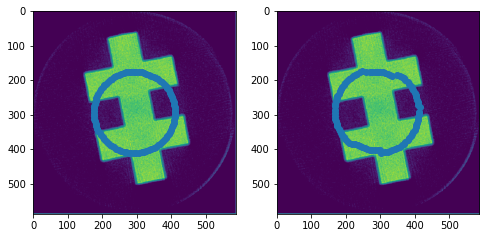

In [9]:
def displace(snake,F,N,tau):
    return (snake.astype(float) + F*N*tau)

def step(frame,snake,tau = 0.5,iter=1):
    tau = 2
    for i in range(iter):
        N = get_normal(snake)
        F = get_force(frame,snake)
        snake = displace(snake,F,N,tau)
        snake = distribute_points(snake)
        snake = snake.astype(int)
    return snake

frame = gray_frames[0]
snake2 = step(frame,snake,iter=7)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))
ax1.imshow(gray_frames[0])
ax1.scatter(snake[:,0],snake[:,1])
ax2.imshow(gray_frames[0])
ax2.scatter(snake2[:,0],snake2[:,1])

### 7. Write a function which given $\alpha, \beta$ and $n$ constructs a regularization matrix $B_{int}$. Your code from the introductory exercise could be used.
Apply regularization to a snake. Estimate a reasonable values for
the regularization parameters a and b by visualizing the effect of
regularization. You should later fine-tune these values to obtain a
segmentation with the boundary which is both smooth and sufficiently
detailed. This step corresponds to matrix multiplication on
the right hand side of the Eq. (6.3).

$C^t = B_{int}\big(C^{t-1} + \tau \text{diag}(F_{ext})N^{t-1}\big)$

In [11]:
def regularization_matrix_version2(N, alpha, beta):
    d = alpha*np.array([-2, 1, 0, 0]) + beta*np.array([-6, 4, -1, 0])
    D = np.fromfunction(lambda i,j: np.minimum((i-j)%N,(j-i)%N), (N,N), dtype=np.int)
    A = d[np.minimum(D,len(d)-1)]
    return(scipy.linalg.inv(np.eye(N)-A))

/tmp/ipykernel_1691/2635939020.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  D = np.fromfunction(lambda i,j: np.minimum((i-j)%N,(j-i)%N), (N,N), dtype=np.int)


### 8. The quality of the curve representation may deteriorate during evolution, especially if you use a large time step t and/or weak regularization, i.e. small a and b. 
To allow faster evolution without
curve deterioration, you may choose to apply a number of substeps
(implemented as subfunctions) which ensure the quality of the snake

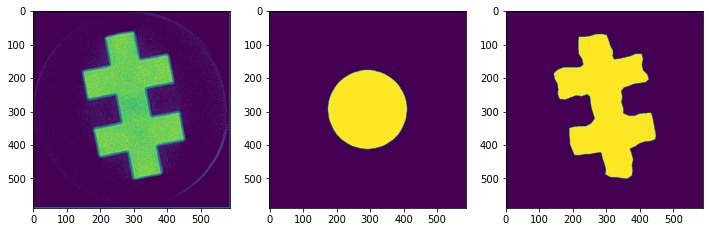

In [19]:
def step_stable(frame,snake,Bint,tau = 0.5,iter=1):
    num_points = np.size(snake[:,0])
    for i in range(iter):
        N = get_normal(snake)
        F = get_force(frame,snake.astype(int),num_points=num_points)
        snake = Bint@displace(snake,F,N,tau,num_points=num_points)
        snake = distribute_points(snake.T)
        snake = remove_intersections(snake)
        snake = snake.T
    return snake

frame = gray_frames[0]
snake = get_snake(frame)
snake2 = step_stable(frame,snake,Bint,tau=20,iter=100)

seg1, _ = get_int_ext(frame,snake)
seg2, _ = get_int_ext(frame,snake2)

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,8))
ax1.imshow(frame)
ax2.imshow(seg1)
ax3.imshow(seg2)